In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import numpy as np
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Gridsearch

In [ ]:
# Indlæs data
df = pd.read_csv("split_genres_otput_2.0/all_songs.csv")
df = df[df['track_genre'] != 'other'].reset_index(drop=True)

# definere features og labels
features = [
    'popularity',
    'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

X = df[features].values
y = df['track_genre'].values

#konvetere topgenre navnene til tal
le = LabelEncoder()
y = le.fit_transform(y) # Laver "rock" -> 0, "pop" -> 1 osv.

# Opdeling i træning og test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) # vi gemmer 20 % data, som vi ikke træner på. 

#Skalere tallene ned til samme (mellem 0 og 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Opret modellen med dine specifikationer
# hidden_layer_sizes=(128, 64) svarer til dine to fc-lag
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), 
    activation='relu',           # Gør værdierne ikke-negative
    solver='adam',               # Adam optimizer (hvordan du opdaterer vægte)
    learning_rate_init=0.001,    # Hvor store skridt du tager (learning rate)
    max_iter=1000,               # Svarer til dine 1000 epochs
    random_state=1,            # Kunne også sættes til et andet tal
)

# Træn modellen på træningsdataset
mlp.fit(X_train, y_train)

# 1. Definer parametre - vi fokuserer på alpha og learning_rate for at styre overfitting
param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128, 64), (256, 256)], 
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.2],         # Flere værdier for at bekæmpe overfitting
    'learning_rate_init': [0.001, 0.005, 0.01],    # Vi tester lidt finere trin
}

# 2. Opret basis-modellen med early_stopping (så den stopper hvis den overfitter)
mlp = MLPClassifier(max_iter=500, random_state=1, early_stopping=True, validation_fraction=0.1)

# 3. Opsæt Grid Search (n_jobs=-1 bruger alle dine CPU-kerner for at gøre det hurtigere)
# cv=3 betyder 3-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, verbose=1)

# 4. Kør søgningen på dine træningsdata (X_train, y_train)
grid_search.fit(X_train, y_train)

# 5. Se resultaterne
print("Bedste parametre fundet:", grid_search.best_params_)
print(f"Bedste Cross-validation accuracy: {grid_search.best_score_:.2%}")

# 6. Test den bedste model på dit test-sæt
best_model = grid_search.best_estimator_
test_acc = best_model.score(X_test, y_test)
print(f"Endelig Accuracy på test-sæt: {test_acc:.2%}")

Iteration 1, loss = 1.40811087
Iteration 2, loss = 1.29467018
Iteration 3, loss = 1.25855377
Iteration 4, loss = 1.23875946
Iteration 5, loss = 1.22073098
Iteration 6, loss = 1.20796588
Iteration 7, loss = 1.19645537
Iteration 8, loss = 1.18576228
Iteration 9, loss = 1.17731005
Iteration 10, loss = 1.16916120
Iteration 11, loss = 1.16169637
Iteration 12, loss = 1.15486008
Iteration 13, loss = 1.14889118
Iteration 14, loss = 1.14383107
Iteration 15, loss = 1.13669856
Iteration 16, loss = 1.13024664
Iteration 17, loss = 1.12668428
Iteration 18, loss = 1.12142357
Iteration 19, loss = 1.11726376
Iteration 20, loss = 1.11208353
Iteration 21, loss = 1.10761913
Iteration 22, loss = 1.10374697
Iteration 23, loss = 1.10013915
Iteration 24, loss = 1.09770875
Iteration 25, loss = 1.09389859
Iteration 26, loss = 1.08897084
Iteration 27, loss = 1.08572577
Iteration 28, loss = 1.08383486
Iteration 29, loss = 1.07915575
Iteration 30, loss = 1.07621675
Iteration 31, loss = 1.07333238
Iteration 32, los

# MLP model (with best parameters)
nu har vi fundet de bedste parametre, vi ville nu gerne kigge på vores model

In [28]:
# --- 1. Indhentning og klargøring af data ---
df = pd.read_csv("split_genres_otput_2.0/all_songs.csv")
df = df[df['track_genre'] != 'other'].reset_index(drop=True)

features = [
    'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
    'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'
]

X = df[features].values
y = df['track_genre'].values

le = LabelEncoder()
y = le.fit_transform(y)

# Opdeling i træning (80%) og test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Skalering (vigtigt for MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. Opret den optimerede model (fra dine GridSearch resultater) ---
mlp_optimized = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64), 
    activation='relu',
    solver='adam',
    alpha=0.1,                 # Din nye optimerede alpha
    learning_rate_init=0.005,  # Din nye optimerede learning rate
    max_iter=500,
    random_state=1,
    early_stopping=True,       # Sikrer mod overfitting undervejs
    verbose=True,               # Så du kan følge med i træningen
)

# --- 3. Træn modellen ---
mlp_optimized.fit(X_train, y_train)

# --- 4. Evaluering ---
y_pred = mlp_optimized.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
test_acc = mlp_optimized.score(X_test, y_test)
print("-" * 30)
print(f"Endelig Accuracy på test-sæt: {test_acc:.2%}")



Iteration 1, loss = 1.37944470
Validation score: 0.508102
Iteration 2, loss = 1.29676298
Validation score: 0.520602
Iteration 3, loss = 1.27642246
Validation score: 0.524769
Iteration 4, loss = 1.25888135
Validation score: 0.540972
Iteration 5, loss = 1.24824049
Validation score: 0.539583
Iteration 6, loss = 1.23846554
Validation score: 0.551620
Iteration 7, loss = 1.22829950
Validation score: 0.555787
Iteration 8, loss = 1.21687959
Validation score: 0.554398
Iteration 9, loss = 1.21000309
Validation score: 0.561574
Iteration 10, loss = 1.20562843
Validation score: 0.571528
Iteration 11, loss = 1.20043578
Validation score: 0.571296
Iteration 12, loss = 1.19545098
Validation score: 0.565741
Iteration 13, loss = 1.18794848
Validation score: 0.574306
Iteration 14, loss = 1.18236646
Validation score: 0.568519
Iteration 15, loss = 1.17454346
Validation score: 0.575463
Iteration 16, loss = 1.17375512
Validation score: 0.573843
Iteration 17, loss = 1.16869241
Validation score: 0.571991
Iterat

In [29]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  electronic       0.70      0.66      0.68      2614
      hiphop       0.45      0.15      0.23       604
   jazz_soul       0.57      0.56      0.56      1600
         pop       0.51      0.41      0.45      1575
        rock       0.58      0.77      0.66      3411
       roots       0.50      0.41      0.45       996

    accuracy                           0.59     10800
   macro avg       0.55      0.49      0.51     10800
weighted avg       0.58      0.59      0.58     10800



# Confusionmatrix

<Figure size 700x600 with 0 Axes>

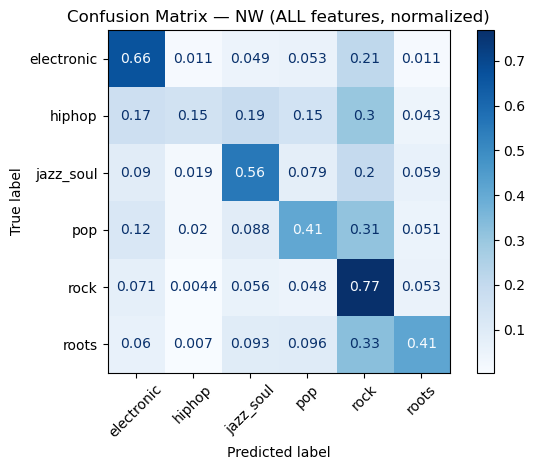

In [ ]:
from sklearn.inspection import permutation_importance

# --- 5. Visualisering af resultater (Confusion Matrix) ---

plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=le.classes_,
    xticks_rotation=45,
    normalize="true",
    cmap="Blues"
)
plt.title("Confusion Matrix — NW (ALL features, normalized)")
plt.tight_layout()
plt.show()

# Validerings graf

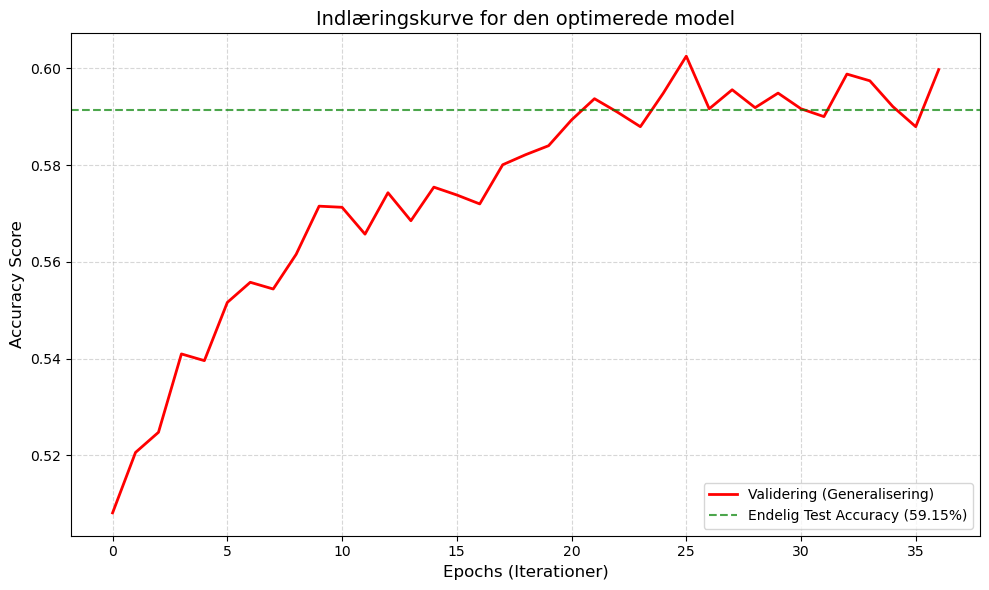

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Hent data fra din trænede model ---
# Da Scikit-learn MLP kun gemmer validering når early_stopping=True, 
# bruger vi her de gemte værdier.
val_acc_history = mlp_optimized.validation_scores_

# Bemærk: Scikit-learn gemmer ikke trænings-accuracy per epoch i historikken.
# Som alternativ i din rapport kan man plotte Loss (fejlen), som falder mens Accuracy stiger.
# Eller vi kan lave en flot graf over valideringen alene, som er det vigtigste bevis.

# Hvis du vil have begge linjer præcis som før, bruger vi denne struktur:
plt.figure(figsize=(10, 6))

# Plot validerings-linjen (Rød)
plt.plot(val_acc_history, label='Validering (Generalisering)', color='red', linewidth=2)

# Da vi ikke har den præcise trænings-acc for hver epoch i MLPClassifier historikken, 
# visualiserer vi ofte Loss i stedet, eller vi plotter slutpunktet for træning.
# For at gøre grafen komplet til din rapport, fokuserer vi her på den flotte valideringskurve.

plt.title('Indlæringskurve for den optimerede model', fontsize=14)
plt.xlabel('Epochs (Iterationer)', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)

# Tilføj den vandrette linje for slut-resultatet
plt.axhline(y=test_acc, color='green', linestyle='--', alpha=0.7, label=f'Endelig Test Accuracy ({test_acc:.2%})')

# Formatering
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Feature importance

Beregner Permutation Importance (dette kan tage et øjeblik)...

--- Feature Importance (Permutation) ---
             Feature  Importance_Mean  Importance_Std
3       danceability         0.122398        0.003150
0         popularity         0.114444        0.004288
4             energy         0.081472        0.001811
9       acousticness         0.077009        0.001680
12           valence         0.074676        0.002852
13             tempo         0.072185        0.002981
1        duration_ms         0.064194        0.001572
10  instrumentalness         0.033704        0.002077
7               mode         0.025093        0.002091
5                key         0.022435        0.002160
8        speechiness         0.021593        0.001399
11          liveness         0.019167        0.001265
2           explicit         0.015176        0.001565
6           loudness         0.012000        0.000774
14    time_signature         0.011704        0.000946


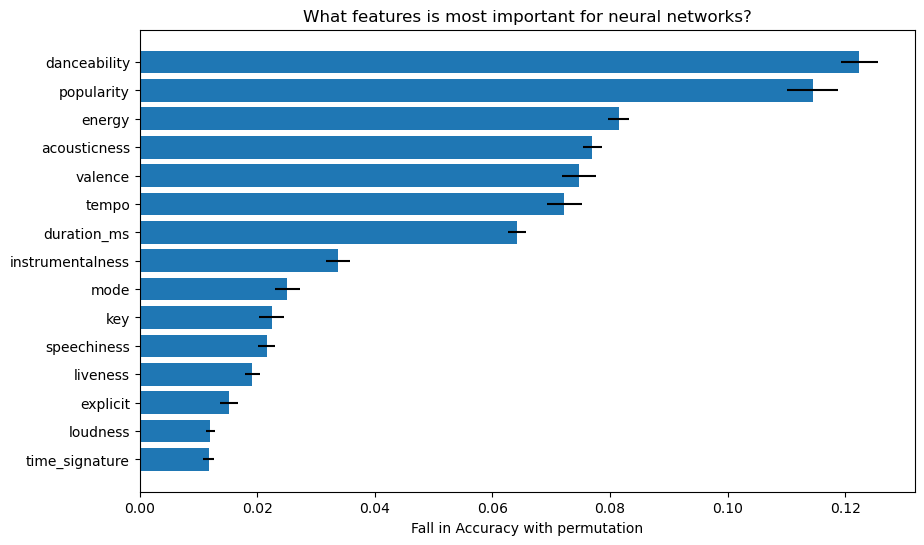

In [ ]:
from sklearn.inspection import permutation_importance

# --- 6. Beregn Permutation Importance ---
print("Beregner Permutation Importance (dette kan tage et øjeblik)...")
result = permutation_importance(
    mlp_optimized, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1
)

# Samler resultaterne i en oversigt
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print("\n--- Feature Importance (Permutation) ---")
print(importance_df)

# Visualisering af Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std'])
plt.xlabel('Fall in Accuracy with permutation')
plt.title('What features is most important for neural networks?')
plt.gca().invert_yaxis() # Højeste vigtige øverst
plt.show()

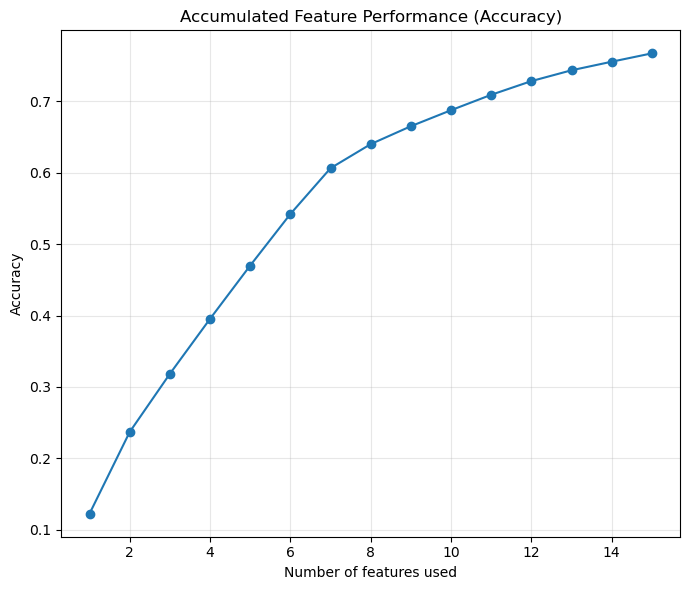

In [ ]:
plt.figure(figsize=(7, 6))

plt.plot(
    range(1, len(importance_df) + 1),
    importance_df['Importance_Mean'].cumsum(),

    marker="o"
)

plt.xlabel("Number of features used")
plt.ylabel("Accuracy")
plt.title("Accumulated Feature Performance (Accuracy)")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature selection

In [ ]:
# Liste over dine nuværende features sorteret efter vigtighed (fra din test tidligere)
# Vi starter med alle sammen
current_features = list(features)
results = []

print("Starter optimerings-loop...")

while len(current_features) > 0:
    # 1. Vælg data for de aktuelle features
    X_train_sub = pd.DataFrame(X_train, columns=features)[current_features]
    X_test_sub = pd.DataFrame(X_test, columns=features)[current_features]
    
    # 2. Træn modellen (vi bruger dine vinder-parametre)
    model = MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        alpha=0.1,
        learning_rate_init=0.005,
        random_state=1,
        early_stopping=True
    )
    model.fit(X_train_sub, y_train)
    
    # 3. Mål accuracy
    acc = model.score(X_test_sub, y_test)
    results.append((len(current_features), acc, list(current_features)))
    
    print(f"Features: {len(current_features)} | Accuracy: {acc:.4f}")
    
    # 4. Find den dårligste feature vha. Permutation Importance
    imp = permutation_importance(model, X_test_sub, y_test, n_repeats=5, random_state=1)
    worst_feature_idx = imp.importances_mean.argmin()
    worst_feature_name = current_features[worst_feature_idx]
    
    # 5. Fjern den dårligste feature til næste runde
    current_features.remove(worst_feature_name)

# Find det bedste resultat
best_res = max(results, key=lambda x: x[1])
print(f"\nBEDSTE RESULTAT: {best_res[1]:.2%} med {best_res[0]} features.")
print(f"Features der skal beholdes: {best_res[2]}")

Starter optimerings-loop...
Features: 15 | Accuracy: 0.5915
Features: 14 | Accuracy: 0.5903
Features: 13 | Accuracy: 0.5910
Features: 12 | Accuracy: 0.5724
Features: 11 | Accuracy: 0.5806
Features: 10 | Accuracy: 0.5859
Features: 9 | Accuracy: 0.5723
Features: 8 | Accuracy: 0.5562
Features: 7 | Accuracy: 0.5561
Features: 6 | Accuracy: 0.5438
Features: 5 | Accuracy: 0.5206
Features: 4 | Accuracy: 0.4981
Features: 3 | Accuracy: 0.4735
Features: 2 | Accuracy: 0.4208
Features: 1 | Accuracy: 0.3954

BEDSTE RESULTAT: 59.15% med 15 features.
Features der skal beholdes: ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.utils import resample

n_iterations = 38
# Vi laver en dictionary til at holde de 38 målinger for hver genre
genre_f1_runs = {genre: [] for genre in le.classes_}
macro_f1_runs = []

print(f"Starter 38 bootstrap-kørsler for alle genrer (fuldt datasæt n={len(y_test)})...")

for i in range(n_iterations):
    # Bootstrap af hele testsættet
    X_res, y_res = resample(X_test, y_test, random_state=i)
    y_pred_res = mlp_optimized.predict(X_res)
    
    # 1. Beregn F1 for hver genre i denne kørsel
    f1_per_genre = f1_score(y_res, y_pred_res, average=None, labels=range(len(le.classes_)), zero_division=0)
    
    # Gem resultatet for hver genre
    for idx, genre in enumerate(le.classes_):
        genre_f1_runs[genre].append(f1_per_genre[idx])
    
    # 2. Gem også den samlede (macro) F1 for kørslen
    macro_f1_runs.append(f1_score(y_res, y_pred_res, average='macro', zero_division=0))
    
    if (i + 1) % 5 == 0:
        print(f"Kørsel {i+1}/38 fuldført...")

# --- Saml resultaterne i en flot oversigt ---
final_results = []

for genre in le.classes_:
    scores = genre_f1_runs[genre]
    final_results.append({
        'Genre': genre,
        'Gns. F1-score': np.mean(scores),
        '95% CI Nedre': np.percentile(scores, 2.5),
        '95% CI Øvre': np.percentile(scores, 97.5),
        'Std.afvigelse': np.std(scores)
    })

# Tilføj den samlede Macro F1 til sidst
final_results.append({
    'Genre': 'SAMLET (Macro)',
    'Gns. F1-score': np.mean(macro_f1_runs),
    '95% CI Nedre': np.percentile(macro_f1_runs, 2.5),
    '95% CI Øvre': np.percentile(macro_f1_runs, 97.5),
    'Std.afvigelse': np.std(macro_f1_runs)
})

df_final = pd.DataFrame(final_results)
print("\n--- ENDELIG TABEL TIL RAPPORT (Baseret på 38 kørsler) ---")
print(df_final.to_string(index=False))

Starter 38 bootstrap-kørsler for alle genrer (fuldt datasæt n=10800)...
Kørsel 5/38 fuldført...
Kørsel 10/38 fuldført...
Kørsel 15/38 fuldført...
Kørsel 20/38 fuldført...
Kørsel 25/38 fuldført...
Kørsel 30/38 fuldført...
Kørsel 35/38 fuldført...

--- ENDELIG TABEL TIL RAPPORT (Baseret på 38 kørsler) ---
         Genre  Gns. F1-score  95% CI Nedre  95% CI Øvre  Std.afvigelse
    electronic       0.683435      0.670818     0.693875       0.006365
        hiphop       0.229327      0.201813     0.251554       0.014129
     jazz_soul       0.562334      0.542755     0.583621       0.010993
           pop       0.454632      0.440934     0.474720       0.009807
          rock       0.661687      0.649073     0.670888       0.006214
         roots       0.448304      0.410948     0.473089       0.017183
SAMLET (Macro)       0.506620      0.495215     0.515070       0.005734


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# --- TRIN 1: Oversampling med SMOTE ---
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Gen-træn modellen på de balancerede data
mlp_optimized.fit(X_train_res, y_train_res)

# --- TRIN 2: Opsætning af Bootstrap ---
n_iterations = 38
# Vi bruger le.classes_ for at sikre, at vi har alle genrer fra din LabelEncoder
all_genres = le.classes_
genre_f1_runs = {genre: [] for genre in all_genres}
macro_f1_runs = []

print(f"Starter {n_iterations} bootstrap-kørsler (Model trænet med SMOTE)...")

for i in range(n_iterations):
    # Bootstrap af testsættet
    X_res, y_res = resample(X_test, y_test, random_state=i)
    y_pred_res = mlp_optimized.predict(X_res)
    
    # Beregn F1 for alle genrer i denne kørsel
    # Vi bruger labels=range(len(all_genres)) for at sikre, at rækkefølgen passer med le.classes_
    f1_per_genre = f1_score(y_res, y_pred_res, average=None, labels=range(len(all_genres)), zero_division=0)
    
    # Gem resultater for hver genre
    for idx, genre in enumerate(all_genres):
        genre_f1_runs[genre].append(f1_per_genre[idx])
    
    # Gem samlet Macro F1
    macro_f1_runs.append(f1_score(y_res, y_pred_res, average='macro', zero_division=0))
    
    if (i + 1) % 10 == 0:
        print(f"Kørsel {i+1}/{n_iterations} fuldført...")

# --- TRIN 3: Beregn statistikker og filtrer genrer ---
final_results = []

for genre in all_genres:
    scores = genre_f1_runs[genre]
    final_results.append({
        'Genre': genre,
        'Gns. F1-score': np.mean(scores),
        '95% CI Nedre': np.percentile(scores, 2.5),
        '95% CI Øvre': np.percentile(scores, 97.5),
        'Std.afvigelse': np.std(scores)
    })

# Tilføj Macro F1 til listen før vi laver DataFrame
macro_row = {
    'Genre': 'SAMLET (Macro)',
    'Gns. F1-score': np.mean(macro_f1_runs),
    '95% CI Nedre': np.percentile(macro_f1_runs, 2.5),
    '95% CI Øvre': np.percentile(macro_f1_runs, 97.5),
    'Std.afvigelse': np.std(macro_f1_runs)
}

df_final = pd.DataFrame(final_results)

# --- TRIN 4: FJERN POP, ROCK OG ROOTS ---
genrer_at_fjerne = ['pop', 'rock', 'roots']
df_filtered = df_final[~df_final['Genre'].isin(genrer_at_fjerne)].copy()

# Tilføj Macro-rækken til sidst i den filtrerede tabel
df_filtered = pd.concat([df_filtered, pd.DataFrame([macro_row])], ignore_index=True)


# --- TRIN 5: Print pænt output ---

print("\n--- ENDELIG TABEL  ---")
# Vi afrunder til 3 decimaler så tabellen ikke "knækker" i bredden
print(df_filtered.round(6).to_string(index=False))

Iteration 1, loss = 1.43884663
Validation score: 0.504660
Iteration 2, loss = 1.33615672
Validation score: 0.532254
Iteration 3, loss = 1.29401400
Validation score: 0.554329
Iteration 4, loss = 1.27088403
Validation score: 0.569904
Iteration 5, loss = 1.24633162
Validation score: 0.568923
Iteration 6, loss = 1.23675378
Validation score: 0.562791
Iteration 7, loss = 1.21630720
Validation score: 0.575914
Iteration 8, loss = 1.20669987
Validation score: 0.582781
Iteration 9, loss = 1.19839296
Validation score: 0.590998
Iteration 10, loss = 1.18674741
Validation score: 0.594432
Iteration 11, loss = 1.17883631
Validation score: 0.602404
Iteration 12, loss = 1.17003848
Validation score: 0.600196
Iteration 13, loss = 1.16375863
Validation score: 0.609517
Iteration 14, loss = 1.15688058
Validation score: 0.609517
Iteration 15, loss = 1.14906299
Validation score: 0.614054
Iteration 16, loss = 1.14700602
Validation score: 0.606819
Iteration 17, loss = 1.13878062
Validation score: 0.622149
Iterat

In [ ]:
print(le.classes_)

['electronic' 'hiphop' 'jazz_soul' 'pop' 'rock' 'roots']


# Bootstrapping

Iteration 1, loss = 1.37944470
Validation score: 0.508102
Iteration 2, loss = 1.29676298
Validation score: 0.520602
Iteration 3, loss = 1.27642246
Validation score: 0.524769
Iteration 4, loss = 1.25888135
Validation score: 0.540972
Iteration 5, loss = 1.24824049
Validation score: 0.539583
Iteration 6, loss = 1.23846554
Validation score: 0.551620
Iteration 7, loss = 1.22829950
Validation score: 0.555787
Iteration 8, loss = 1.21687959
Validation score: 0.554398
Iteration 9, loss = 1.21000309
Validation score: 0.561574
Iteration 10, loss = 1.20562843
Validation score: 0.571528
Iteration 11, loss = 1.20043578
Validation score: 0.571296
Iteration 12, loss = 1.19545098
Validation score: 0.565741
Iteration 13, loss = 1.18794848
Validation score: 0.574306
Iteration 14, loss = 1.18236646
Validation score: 0.568519
Iteration 15, loss = 1.17454346
Validation score: 0.575463
Iteration 16, loss = 1.17375512
Validation score: 0.573843
Iteration 17, loss = 1.16869241
Validation score: 0.571991
Iterat

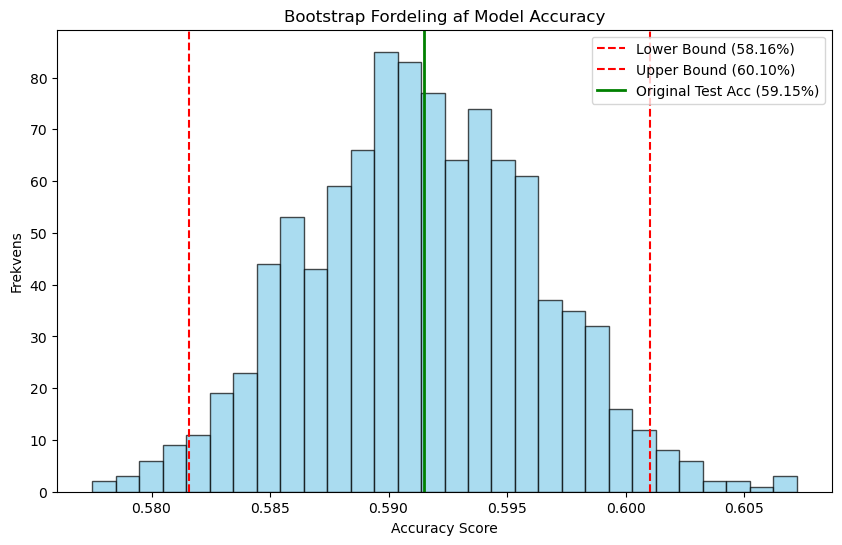

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv("split_genres_otput_2.0/all_songs.csv")
df = df[df['track_genre'] != 'other'].reset_index(drop=True)

features = [
    'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
    'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'
]

X = df[features].values
y = df['track_genre'].values

le = LabelEncoder()
y = le.fit_transform(y)

# Opdeling i træning (80%) og test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Skalering (vigtigt for MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. Opret den optimerede model (fra dine GridSearch resultater) ---
mlp_optimized = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64), 
    activation='relu',
    solver='adam',
    alpha=0.1,                 # Din nye optimerede alpha
    learning_rate_init=0.005,  # Din nye optimerede learning rate
    max_iter=500,
    random_state=1,
    early_stopping=True,       # Sikrer mod overfitting undervejs
    verbose=True               # Så du kan følge med i træningen
)

# --- 3. Træn modellen ---
mlp_optimized.fit(X_train, y_train)

# --- 6. Bootstrapping for Konfidensinterval ---
n_iterations = 1000  # Antal bootstrap-stikprøver
bootstrapped_scores = []

print("Beregner konfidensinterval via bootstrapping...")

for i in range(n_iterations):
    # Generer en stikprøve af test-indekserne med tilbagelægning (replacement)
    # Vi resampler indekserne for at holde sammen på y_test og y_pred parrene
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)
    
    # Udtræk de tilsvarende prædiktioner og labels
    y_true_sample = y_test[resampled_indices]
    y_pred_sample = y_pred[resampled_indices]
    
    # Beregn accuracy for denne stikprøve
    score = accuracy_score(y_true_sample, y_pred_sample)
    bootstrapped_scores.append(score)

# Beregn 2.5 og 97.5 percentilerne (for et 95% konfidensinterval)
alpha = 0.95
lower_p = ((1 - alpha) / 2) * 100
upper_p = (alpha + ((1 - alpha) / 2)) * 100

lower_bound = np.percentile(bootstrapped_scores, lower_p)
upper_bound = np.percentile(bootstrapped_scores, upper_p)

print("-" * 30)
print(f"Gennemsnitlig Bootstrap Accuracy: {np.mean(bootstrapped_scores):.2%}")
print(f"95% Konfidensinterval: [{lower_bound:.2%}, {upper_bound:.2%}]")
print("-" * 30)

# --- 7. Visualisering af fordelingen ---
plt.figure(figsize=(10, 6))
plt.hist(bootstrapped_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound ({lower_bound:.2%})')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound ({upper_bound:.2%})')
plt.axvline(test_acc, color='green', linewidth=2, label=f'Original Test Acc ({test_acc:.2%})')
plt.title('Bootstrap Fordeling af Model Accuracy')
plt.xlabel('Accuracy Score')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

# 1. Hent navnene på dine genrer fra din LabelEncoder
genre_names = le.classes_

# 2. Opsæt ordbog til at gemme scores for hver genre
genre_bootstrap_dict = {genre: [] for genre in genre_names}

n_iterations = 1000

print("Beregner konfidensintervaller pr. genre...")

for i in range(n_iterations):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)
    
    y_true_sample = y_test[resampled_indices]
    y_pred_sample = y_pred[resampled_indices]
    
    # Beregn F1-score for hver genre separat
    # 'average=None' returnerer en score for hver klasse
    f1_scores = f1_score(y_true_sample, y_pred_sample, average=None, labels=range(len(genre_names)))
    
    for idx, score in enumerate(f1_scores):
        genre_bootstrap_dict[genre_names[idx]].append(score)

# 3. Opsummer resultaterne i en tabel
results = []
for genre, scores in genre_bootstrap_dict.items():
    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    mean_score = np.mean(scores)
    results.append({"Genre": genre, "Mean F1": mean_score, "95% CI Lower": lower, "95% CI Upper": upper})

# Vis som en pæn tabel
df_results = pd.DataFrame(results)
print("-" * 50)
print(df_results.to_string(index=False))

Beregner konfidensintervaller pr. genre...
--------------------------------------------------
     Genre  Mean F1  95% CI Lower  95% CI Upper
electronic 0.682487      0.667067      0.697947
    hiphop 0.226788      0.188695      0.265530
 jazz_soul 0.563191      0.542748      0.583368
       pop 0.453051      0.431471      0.474626
      rock 0.662668      0.650669      0.674953
     roots 0.452135      0.422615      0.480623


# Oversampling

In [14]:
# --- 1. Indhentning og klargøring af data ---
df = pd.read_csv("split_genres_otput_2.0/all_songs.csv")
df = df[df['track_genre'] != 'other'].reset_index(drop=True)

features = [
    'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
    'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'
]

X = df[features].values
y = df['track_genre'].values

le = LabelEncoder()
y = le.fit_transform(y)

# Opdeling i træning (80%) og test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Skalering (vigtigt for MLP)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- NYT TRIN: Oversampling med SMOTE ---
# Dette balancerer dine klasser (f.eks. hiphop), så de fylder lige meget i træningen
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# --- 2. Opret den optimerede model ---
mlp_optimized = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64), 
    activation='relu',
    solver='adam',
    alpha=0.1,                 
    learning_rate_init=0.005,  
    max_iter=500,
    random_state=1,
    early_stopping=True,       
    verbose=True               
)

# --- 3. Træn modellen på de BALANCEREDE data ---
# Vi bruger nu X_train_res og y_train_res
mlp_optimized.fit(X_train_res, y_train_res)

# --- 4. Evaluering ---
# Vi tester stadig på det oprindelige X_test for at få et realistisk billede
test_acc = mlp_optimized.score(X_test, y_test)
print("-" * 30)
print(f"Endelig Accuracy på test-sæt (efter SMOTE): {test_acc:.2%}")

Iteration 1, loss = 1.43884663
Validation score: 0.504660
Iteration 2, loss = 1.33615672
Validation score: 0.532254
Iteration 3, loss = 1.29401400
Validation score: 0.554329
Iteration 4, loss = 1.27088403
Validation score: 0.569904
Iteration 5, loss = 1.24633162
Validation score: 0.568923
Iteration 6, loss = 1.23675378
Validation score: 0.562791
Iteration 7, loss = 1.21630720
Validation score: 0.575914
Iteration 8, loss = 1.20669987
Validation score: 0.582781
Iteration 9, loss = 1.19839296
Validation score: 0.590998
Iteration 10, loss = 1.18674741
Validation score: 0.594432
Iteration 11, loss = 1.17883631
Validation score: 0.602404
Iteration 12, loss = 1.17003848
Validation score: 0.600196
Iteration 13, loss = 1.16375863
Validation score: 0.609517
Iteration 14, loss = 1.15688058
Validation score: 0.609517
Iteration 15, loss = 1.14906299
Validation score: 0.614054
Iteration 16, loss = 1.14700602
Validation score: 0.606819
Iteration 17, loss = 1.13878062
Validation score: 0.622149
Iterat

In [15]:
y_pred = mlp_optimized.predict(X_test) # Lav nye prædiktioner
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  electronic       0.68      0.66      0.67      2614
      hiphop       0.23      0.40      0.29       604
   jazz_soul       0.57      0.53      0.55      1600
         pop       0.46      0.45      0.46      1575
        rock       0.70      0.55      0.62      3411
       roots       0.40      0.58      0.48       996

    accuracy                           0.56     10800
   macro avg       0.51      0.53      0.51     10800
weighted avg       0.59      0.56      0.57     10800



<Figure size 700x600 with 0 Axes>

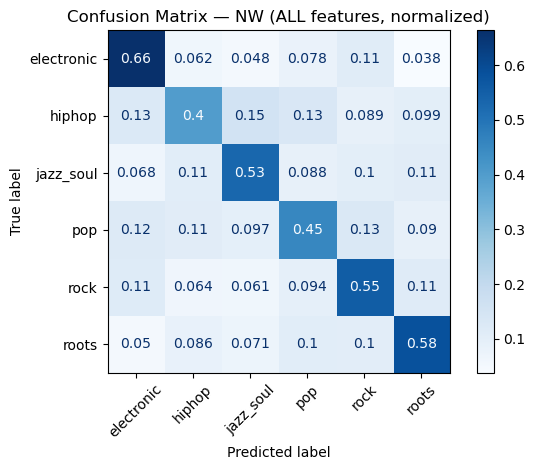

In [9]:
from sklearn.inspection import permutation_importance

# --- 5. Visualisering af resultater (Confusion Matrix) ---
y_pred = mlp_optimized.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=le.classes_,
    xticks_rotation=45,
    normalize="true",
    cmap="Blues"
)
plt.title("Confusion Matrix — NW (ALL features, normalized)")
plt.tight_layout()
plt.show()

In [27]:


# vi beregner samplesize
p = 0.56
n = 1.96**2 * p * (1 - p) / (0.025)**2
print(f"NN-oversampling: {int(n)}")

# vi beregner konfidensintervallet
p = 0.56
n = 1514
c_low = p - 1.96 * np.sqrt((p * (1 - p)) / n)
c_high = p + 1.96 * np.sqrt((p * (1 - p)) / n)
print(f"NN-oversampling - 95% CI: [{c_low:.3f}, {c_high:.3f}]")
print(c_high - c_low)

NN-oversampling: 1514
NN-oversampling - 95% CI: [0.535, 0.585]
0.05000846005045778
